<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Community-Prediction-Competition-(kaggle)" data-toc-modified-id="Community-Prediction-Competition-(kaggle)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Community Prediction Competition (kaggle)</a></span><ul class="toc-item"><li><span><a href="#Data-desription" data-toc-modified-id="Data-desription-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data desription</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model selection</a></span></li><li><span><a href="#Prediction-test-data" data-toc-modified-id="Prediction-test-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Prediction test data</a></span></li></ul></li></ul></div>

# Heart diseases prediction
## Community Prediction Competition (kaggle)

**The purpose of this project** is heart disease risk prediction from patient lifestyle information. \
**The evaluation metric** for this competition is *ROC AUC score*.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# data
train_data = pd.read_csv('train.csv')
display(train_data.head())

test_data = pd.read_csv('test.csv')
display(test_data.head())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


### Data desription
The **features** includes 12 columns with the characteristics of the patient (`age`, `gender`, `height`, `weight`, `smoke`, `alco`, `active`) and his results of medical analyzes (`ap_hi`, `ap_lo`, `cholesterol`, `gluc`). Column called `cardio` is the **target** and presents only in *train_data*.

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


For machine learning, the `id` column is useless. 

In [5]:
train_data.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

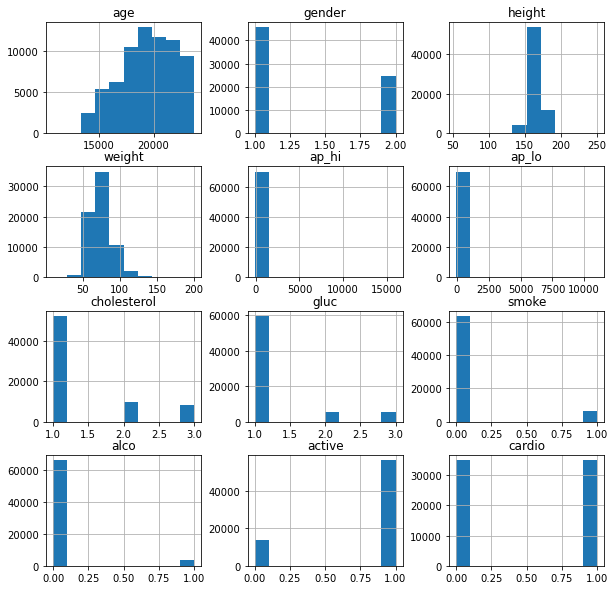

In [6]:
# column distributions
train_data.hist(figsize=(10, 10))
plt.show()

Because of all features is integer values, they need to be standartized to be able to use different algorithms. In addition:
- In the `age` column, we need to check the correctness of the data entry (abnormally large values). 
- Values from the `gender`column should be changed to 0-1 (binary feature).
- Rare and anomalously high values should be investigated in `height`, `weight`, `ap_hi`, `ap_lo` columns.

Class imbalance is not observed in the target (`cardio`). 

### Preprocessing

In [7]:
# 'age'
train_data['age'].min() # 29 years

10798

The age is most likely to be given in days.

In [8]:
train_data['age'] = (train_data['age'] / 365).astype(int)
test_data['age'] = (test_data['age'] / 365).astype(int)

train_data['age']

0        50
1        55
2        51
3        48
4        47
         ..
69995    52
69996    61
69997    52
69998    61
69999    56
Name: age, Length: 70000, dtype: int32

In [9]:
# 'gender'
train_data['gender'] = train_data['gender'].replace(1, 0).replace(2, 1)
test_data['gender'] = test_data['gender'].replace(1, 0).replace(2, 1)

train_data['gender']

0        1
1        0
2        0
3        1
4        0
        ..
69995    1
69996    0
69997    1
69998    0
69999    0
Name: gender, Length: 70000, dtype: int64

In [10]:
# # 'cholesterol'
# train_data['cholesterol'] = train_data['cholesterol'].replace(1, -1).replace(2, 0).replace(3, 1)
# test_data['cholesterol'] = test_data['cholesterol'].replace(1, -1).replace(2, 0).replace(3, 1)

# # 'gluc'
# train_data['gluc'] = train_data['gluc'].replace(1, -1).replace(2, 0).replace(3, 1)
# test_data['gluc'] = test_data['gluc'].replace(1, -1).replace(2, 0).replace(3, 1)

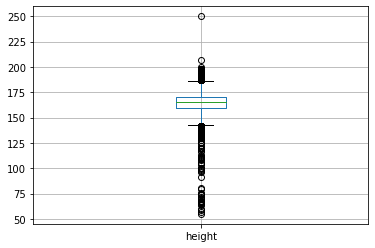

In [11]:
# 'height'
train_data.boxplot('height')
plt.show()

According to wikipedia, abnormally short height for an adult is 147 cm. Remove values above 200 and below 150 from the train dataset.

In [12]:
'{:.0%}'.format(train_data.loc[(train_data['height'] > 200)|(train_data['height'] < 150)].shape[0] / train_data.shape[0])

'2%'

In [13]:
train_data = train_data.loc[(train_data['height'] <= 200)&(train_data['height'] >= 150)]

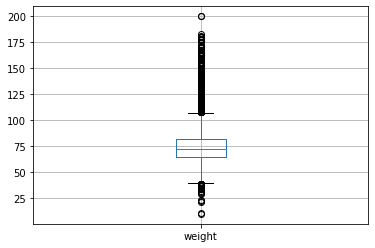

In [14]:
# 'weight'
train_data.boxplot('weight')
plt.show()

In [15]:
'{:.0%}'.format(train_data.loc[(train_data['weight'] < 45)|(train_data['weight'] > 110)].shape[0] / train_data.shape[0])

'2%'

Remove values above 110 and below 45 from the train dataset.

In [16]:
train_data = train_data.loc[(train_data['weight'] >= 45)&(train_data['weight'] <= 110)]
train_data['weight'] = train_data['weight'].astype(int)

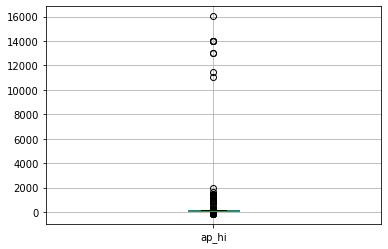

In [17]:
# 'ap_hi'
train_data.boxplot('ap_hi')
plt.show()

`ap_hi` contains values of systolic blood pressure, which should be between 24 and 240.

In [18]:
# correct ap_hi values 
def correct_aphi_values(value):
    if value < 0:
        return abs(value)
    elif value < 3:
        return value*100
    elif value <= 24:
        return value*10
    elif value > 10000:
        return value / 100
    elif value > 300:
        return value / 10
    
    return value

In [19]:
train_data['ap_hi'] = train_data['ap_hi'].apply(correct_aphi_values)
test_data['ap_hi'] = test_data['ap_hi'].apply(correct_aphi_values)

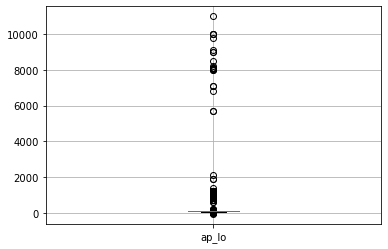

In [20]:
# 'ap_lo'
train_data.boxplot('ap_lo')
plt.show()

`ap_lo` is Diastolic blood pressure. Available range from 15 to 150. 

In [21]:
# correct ap_lo values 
def correct_aplo_values(value):
    if value < 0:
        return abs(value)
    elif value < 3:
        return value*100
    elif value <= 15:
        return value*10
    elif value > 4000:
        return value / 100
    elif value > 150:
        return value / 10
    
    return value

In [22]:
train_data['ap_lo'] = train_data['ap_lo'].apply(correct_aplo_values)
test_data['ap_lo'] = test_data['ap_lo'].apply(correct_aplo_values)

Target and features:

In [23]:
# train_data
features_train = train_data.drop(columns=['cardio'])
target_train = train_data['cardio']

# test_data
features_test = test_data

Standardization of numeric (not binary) data:

In [24]:
numeric = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.414510,1,0.436143,-0.922015,-0.993270,-0.147880,-0.533158,-0.391198,0,0,1
1,0.324868,0,-1.186521,0.901805,0.785130,0.856734,2.427486,-0.391198,0,0,1
2,-0.266635,0,0.030477,-0.763422,0.192330,-1.152494,2.427486,-0.391198,0,0,0
3,-0.710262,1,0.571365,0.663915,1.377931,1.861348,-0.533158,-0.391198,0,0,1
4,-0.858138,0,-1.186521,-1.397795,-1.586070,-2.157108,-0.533158,-0.391198,0,0,0


### Model selection
For each selected ML algorithm (*Random Forest*, ...), let's find the optimal parameters. Cross validation will be used to obtain more accurate averaged results.

In [28]:
%%time

params = { 
    'n_estimators': [i for i in range(100, 600, 100)],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [i for i in range(4, 9)],
    'criterion' :['entropy'],
    'random_state' : [123]
}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='roc_auc', cv= 5)
grid.fit(features_train, target_train)

CPU times: total: 24min 31s
Wall time: 32min 35s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [123]},
             scoring='roc_auc')

In [29]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'random_state': 123}

In [30]:
grid.best_score_

0.8011010098644874

In [33]:
features_test

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.266635,0,-1.456965,0.901805,0.192330,-0.147880,-0.533158,-0.391198,0,0,1
1,-0.118759,1,0.706587,-0.366940,0.192330,0.856734,-0.533158,-0.391198,0,0,1
2,0.324868,0,-0.645633,-0.287643,-0.400470,-0.650187,-0.533158,-0.391198,0,0,0
3,-0.562386,1,2.734917,1.615474,0.192330,0.856734,-0.533158,-0.391198,0,0,1
4,-1.301765,1,0.706587,0.188136,-0.400470,-0.147880,-0.533158,-0.391198,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,0.916371,1,0.706587,2.329143,1.377931,0.856734,-0.533158,-0.391198,0,1,0
29996,-0.414510,0,0.977031,0.346729,-0.993270,-1.152494,-0.533158,-0.391198,0,0,1
29997,0.768495,1,0.571365,-1.001312,-0.400470,-0.147880,-0.533158,-0.391198,0,0,0
29998,-2.041143,1,1.382697,0.505322,-0.400470,-0.147880,0.947164,-0.391198,0,0,0


### Prediction test data

In [36]:
test_data_new = pd.read_csv('test.csv')
test_id = test_data_new['id']
test_id

0            5
1            6
2            7
3           10
4           11
         ...  
29995    99984
29996    99987
29997    99989
29998    99994
29999    99997
Name: id, Length: 30000, dtype: int64

In [38]:
model = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', n_estimators=400, random_state=123)
model.fit(features_train, target_train)
predictions = model.predict_proba(features_test)[:,1]

prediction_df = pd.DataFrame(test_id, columns=['id'])
prediction_df['cardio'] = predictions

prediction_df

,id,cardio
0,5,0.494455
1,6,0.574675
2,7,0.407054
3,10,0.525740
4,11,0.240891
...,...,...
29995,99984,0.851460
29996,99987,0.221819
29997,99989,0.438653
29998,99994,0.349425


In [42]:
# load results to file for kaggle
prediction_df.to_csv('predicted_data.csv', index=False)